In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import re
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from rouge_score import rouge_scorer
import textstat
import nltk
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive
Using device: cuda


In [4]:
# Custom Transformer Model
class CustomResearchGapTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, max_seq_length=1024, dropout=0.1):
        super(CustomResearchGapTransformer, self).__init__()

        self.d_model = d_model
        self.max_seq_length = max_seq_length

        # Embedding layers
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.output_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Encoder and Decoder separately
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoder_layers
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=num_decoder_layers
        )

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Research gap specific layers
        self.gap_classifier = nn.Linear(d_model, 7)
        self.gap_importance = nn.Linear(d_model, 1)

    def create_padding_mask(self, x, pad_token_id=0):
        return (x == pad_token_id)

    def create_causal_mask(self, size):
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        return mask.bool()

    def forward(self, src, tgt, src_pad_mask=None, tgt_pad_mask=None):
        batch_size, src_seq_len = src.shape
        tgt_seq_len = tgt.shape[1]

        # Creating padding masks
        if src_pad_mask is None:
            src_pad_mask = self.create_padding_mask(src)
        if tgt_pad_mask is None:
            tgt_pad_mask = self.create_padding_mask(tgt)

        # Creating causal masks
        tgt_causal_mask = self.create_causal_mask(tgt_seq_len).to(src.device)

        # Embeddings with positional encoding
        src_emb = self.input_embedding(src) * math.sqrt(self.d_model)
        tgt_emb = self.output_embedding(tgt) * math.sqrt(self.d_model)

        src_emb = self.positional_encoding(src_emb)
        tgt_emb = self.positional_encoding(tgt_emb)

        # Encoder forward pass
        encoder_output = self.transformer_encoder(
            src_emb,
            src_key_padding_mask=src_pad_mask
        )

        # Decoder forward pass
        decoder_output = self.transformer_decoder(
            tgt_emb,
            encoder_output,
            tgt_mask=tgt_causal_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            memory_key_padding_mask=src_pad_mask
        )

        # Output projections
        gap_text_logits = self.output_projection(decoder_output)

        # Using encoder output for global context
        encoder_mask = ~src_pad_mask.unsqueeze(-1)  # Inverting mask for multiplication
        masked_encoder_output = encoder_output * encoder_mask.float()
        global_features = masked_encoder_output.sum(dim=1) / encoder_mask.sum(dim=1).float()

        gap_types = self.gap_classifier(global_features)
        gap_scores = self.gap_importance(global_features)

        return {
            'gap_text': gap_text_logits,
            'gap_types': gap_types,
            'gap_scores': gap_scores.squeeze(-1)
        }

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, droput=0.1):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_parameter('pe', nn.Parameter(pe.unsqueeze(0), requires_grad=False))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

print("Custom Transformer Model Defined")

Custom Transformer Model Defined


In [5]:
# Building vocabulary from dataset
class ResearchGapVocabulary:
    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
        self.vocab_size = 4

    def build_vocabulary(self, texts):
        print("Building vocabulary from research papers")

        word_counts = Counter()
        for text in texts:
            # Tokenization
            words = re.findall(r'\b\w+\b', text.lower())
            word_counts.update(words)

        for word, count in word_counts.items():
            if count >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = self.vocab_size
                self.idx2word[self.vocab_size] = word
                self.vocab_size += 1

        print(f"Vocabulary built: {self.vocab_size} words")
        return word_counts

    def text_to_indices(self, text, max_length=512):
        words = re.findall(r'\b\w+\b', text.lower())
        indices = [self.word2idx.get(word, 1) for word in words]  # 1=<UNK>

        # Adding SOS token at beginning, EOS at end
        indices = [2] + indices + [3]  # 2=<SOS>, 3=<EOS>

        # Padding to max_length
        if len(indices) > max_length:
            indices = indices[:max_length-1] + [3]  # Keeping EOS token
        else:
            indices += [0] * (max_length - len(indices))  # 0=<PAD>

        return indices

    def indices_to_text(self, indices):
        # Converting indices back to text
        words = []
        for idx in indices:
            if idx == 3:  # EOS token
                break
            if idx not in [0, 1, 2]:  # Skipping PAD, UNK, SOS
                words.append(self.idx2word.get(idx, '<UNK>'))
        return ' '.join(words)

In [ ]:
# Path to trained model
model_path = '/content/drive/MyDrive/research_gap_epoch_10_model.pt'
checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)

# Loading vocabulary from checkpoint
vocabulary = checkpoint['vocabulary']
print("Vocabulary loaded from model checkpoint.")

# Loading model configuration and initializing the model
model_config = checkpoint['model_config']
model = CustomResearchGapTransformer(**model_config).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("\nModel loaded successfully")
print("Model Details")
print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"Validation Loss: {checkpoint.get('val_loss', float('nan')):.4f}")
print(f"Model Configuration: {model_config}")

Vocabulary loaded from model checkpoint.

Model loaded successfully
Model Details
Epoch: 10
Validation Loss: 2.9525
Model Configuration: {'vocab_size': 53657, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dim_feedforward': 1024, 'dropout': 0.3}


In [7]:
df = pd.read_csv('research_gaps_dataset.csv')

gap_stats = {
    'gap_corpus': df['gap_corpus'].notna().sum(),
    'gap_sentences': df['gap_sentences'].str.len().sum() if 'gap_sentences' in df.columns else 0,
    'future_work_cleaned': df['future_work_cleaned'].notna().sum(),
    'contextual_gaps': df['contextual_gaps'].str.len().sum() if 'contextual_gaps' in df.columns else 0
}

print("gap extraction stats")
for col, count in gap_stats.items():
    print(f"{col}: {count} entries")

print("sample training data")
sample_papers = df[df['gap_corpus'].str.len() > 100].head(3)

for i, (idx, row) in enumerate(sample_papers.iterrows()):
    print(f"\nsample {i+1}")
    print(f"field: {row['field']}")
    print(f"title: {row['title'][:80]}")
    print(f"gap corpus length: {len(row['gap_corpus'])} chars")
    print(f"future work: {row['future_work_cleaned'][:100]}")

gap extraction stats
gap_corpus: 80318 entries
gap_sentences: 40105051 entries
future_work_cleaned: 80318 entries
contextual_gaps: 7455434 entries
sample training data

sample 1
field: Artificial Intelligence
title: Generalizable Representation Learning for Mixture Domain Face Anti-Spoofing
gap corpus length: 3246 chars
future work: ['further enhance interpretability and visualization', 'explore applications to other domains beyond

sample 2
field: Artificial Intelligence
title: Coordinating Human and Agent Behavior in Collective-Risk Scenarios
gap corpus length: 1532 chars
future work: ['explore further applications of anticipatory behavior in complex social scenarios.', 'investigate 

sample 3
field: Artificial Intelligence
title: Adverse Drug Reaction Prediction with Symbolic Latent Dirichlet Allocation
gap corpus length: 2823 chars
future work: ['improvement of the medical ontology system with real-world evidence.', 'addressing issues related 


In [8]:
def create_transformer_training_data(df):

    training_examples = []

    for idx, row in df.iterrows():
        if pd.isna(row['gap_corpus']) or len(row['gap_corpus']) < 50:
            continue

        # Input: combining paper sections
        input_sections = []

        if pd.notna(row['title']):
            input_sections.append(f"Title: {row['title']}")
        if pd.notna(row['abstract_cleaned']):
            input_sections.append(f"Abstract: {row['abstract_cleaned'][:500]}")
        if pd.notna(row['method_proposed_cleaned']):
            input_sections.append(f"Method: {row['method_proposed_cleaned'][:400]}")
        if pd.notna(row['conclusion_cleaned']):
            input_sections.append(f"Conclusion: {row['conclusion_cleaned'][:300]}")

        paper_input = "\n".join(input_sections)

        # Output: extracting research gaps
        research_gaps = []

        if pd.notna(row['future_work_cleaned']) and len(row['future_work_cleaned']) > 20:
            research_gaps.append(f"Future Research: {row['future_work_cleaned'][:200]}")

        if 'gap_sentences' in df.columns and pd.notna(row['gap_sentences']):
            if isinstance(row['gap_sentences'], list) and len(row['gap_sentences']) > 0:
                for gap in row['gap_sentences'][:3]:
                    if len(gap) > 20:
                        research_gaps.append(f"Limitation: {gap[:150]}")

        if len(research_gaps) > 0 and len(paper_input) > 100:
            gap_output = "\n".join(research_gaps)

            training_examples.append({
                'title': row['title'],
                'abstract_cleaned': row['abstract_cleaned'],
                'future_work_cleaned': row['future_work_cleaned'],
                'field': row['field'],
                'input_text': paper_input,
                'target_text': gap_output,
                'paper_id': row['paperID']
            })

    return training_examples

In [9]:
def convert_examples_to_dataframe(examples):
    data_list = []

    for example in examples:
        if isinstance(example, dict):
            row = {
                'title': example.get('title', ''),
                'abstract_cleaned': example.get('abstract_cleaned', ''),
                'future_work_cleaned': example.get('future_work_cleaned', ''),
                'field': example.get('field', 'Unknown'),
                'input_text': example.get('input_text', ''),
                'target_text': example.get('target_text', ''),
                'paper_id': example.get('paper_id', None)
            }
            data_list.append(row)
        else:
            continue

    df = pd.DataFrame(data_list)
    return df

In [10]:
training_examples = create_transformer_training_data(df)

# splitting the data
train_size = int(0.8 * len(training_examples))
val_size = int(0.1 * len(training_examples))
test_size = len(training_examples) - train_size - val_size

train_examples = training_examples[:train_size]
val_examples = training_examples[train_size:train_size + val_size]
test_examples = training_examples[train_size + val_size:]

print("using original split:")
print(f"train: {len(train_examples)} examples")
print(f"val: {len(val_examples)} examples")
print(f"test: {len(test_examples)} examples")
print(f"dataset loaded with shape: {df.shape}")

# converting each split to dataframe
train_df = convert_examples_to_dataframe(train_examples)
val_df = convert_examples_to_dataframe(val_examples)
test_df = convert_examples_to_dataframe(test_examples)

# extracting training texts for novelty analysis
training_texts = []
for _, row in train_df.iterrows():
    if pd.notna(row['future_work_cleaned']) and len(str(row['future_work_cleaned']).strip()) > 10:
        training_texts.append(str(row['future_work_cleaned']))

print(f"extracted {len(training_texts)} training texts for novelty analysis")

# displaying test data sample
print("\ntest data sample:")
print(f"columns: {list(test_df.columns)}")
print("displaying field distribution:")
print(test_df['field'].value_counts().head())

print("\ndisplaying sample test example:")
sample_idx = 0
print(f"title: {test_df.iloc[sample_idx]['title']}")
print(f"field: {test_df.iloc[sample_idx]['field']}")
print(f"abstract: {str(test_df.iloc[sample_idx]['abstract_cleaned'])[:200]}")
if pd.notna(test_df.iloc[sample_idx]['future_work_cleaned']):
    print(f"future work: {str(test_df.iloc[sample_idx]['future_work_cleaned'])[:200]}")

using original split:
train: 64064 examples
val: 8008 examples
test: 8008 examples
dataset loaded with shape: (80318, 33)
extracted 64064 training texts for novelty analysis

test data sample:
columns: ['title', 'abstract_cleaned', 'future_work_cleaned', 'field', 'input_text', 'target_text', 'paper_id']
displaying field distribution:
field
Computer Networks & Communications    3852
Computational Theory                  3205
Computer Security & Cryptography       409
Software Engineering                   401
Database & Information Systems          88
Name: count, dtype: int64

displaying sample test example:
title: The Randomized Midpoint Method for Log-Concave Sampling
field: Computational Theory
abstract: sampling from log-concave distributions is a well researched problem that has many applications in statistics and machine learning. we study the distributions of the form $p^{*}\propto\exp(-f(x))$, wh
future work: ['further optimization of algorithm for even faster sampling', 'explo

In [17]:
def post_process_text(text):
    if not text.lower().startswith(('future', 'further', 'additional', 'more', 'one')):
        text = "Future research should explore " + text

    if text:
        text = text[0].upper() + text[1:]

    # Fixing common grammatical patterns and spacing
    text = re.sub(r'\bfuture research explore\b', 'future research should explore', text, flags=re.IGNORECASE)
    text = re.sub(r'\bfuture research investigate\b', 'future research should investigate', text, flags=re.IGNORECASE)
    text = re.sub(r'\bfurther investigation of\b', 'further investigation into', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+,\s+', ', ', text)  # Fixing spacing

    # Removing consecutive duplicate words
    words = text.split()
    cleaned_words = []
    for i, word in enumerate(words):
        if i == 0 or word.lower() != words[i-1].lower():
            cleaned_words.append(word)
    text = ' '.join(cleaned_words)

    words = text.split()
    cleaned_words = []
    recent_words = []
    for word in words:
        if word.lower() not in recent_words:
            cleaned_words.append(word)

        recent_words.append(word.lower())
        if len(recent_words) > 5:
            recent_words.pop(0)

    text = ' '.join(cleaned_words)

    text = text.strip()
    if text and not text.endswith(('.', '!', '?')):
        text += '.'

    return text


def generate_research_gaps(model, vocabulary, input_text, device,
                                 top_p=0.9, temperature=1.0, max_length=150,
                                 min_length=15, repetition_penalty=1.1):

    model.eval()
    input_indices = vocabulary.text_to_indices(input_text, max_length=512)
    input_tensor = torch.tensor([input_indices]).to(device)
    decoder_input = torch.tensor([[vocabulary.word2idx['<SOS>']]]).to(device)
    generated_tokens = []

    with torch.no_grad():
        src_pad_mask = (input_tensor == 0)
        src_emb = model.positional_encoding(model.input_embedding(input_tensor) * math.sqrt(model.d_model))
        memory = model.transformer_encoder(src_emb, src_key_padding_mask=src_pad_mask)

        for _ in range(max_length):
            # Decoder forward pass
            tgt_causal_mask = model.create_causal_mask(decoder_input.size(1)).to(device)
            tgt_emb = model.positional_encoding(model.output_embedding(decoder_input) * math.sqrt(model.d_model))
            decoder_output = model.transformer_decoder(tgt_emb, memory,
                                                     tgt_mask=tgt_causal_mask,
                                                     memory_key_padding_mask=src_pad_mask)

            # logits for the next token
            next_token_logits = decoder_output[0, -1, :] / temperature

            # repetition penalty to the last few unique tokens
            if repetition_penalty != 1.0 and generated_tokens:
                for token_id in set(generated_tokens[-5:]):
                    next_token_logits[token_id] /= repetition_penalty

            # nucleus sampling
            probabilities = F.softmax(next_token_logits, dim=-1)
            sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            next_token_logits[indices_to_remove] = -float('inf')

            # Sampling the next token from the filtered distribution
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(next_token_probs, num_samples=1)

            # Stopping if EOS token is generated but only after reaching min_length
            if next_token.item() == vocabulary.word2idx['<EOS>']:
                if len(generated_tokens) >= min_length:
                    break

            # Adding the generated token and update the decoder input for the next step
            generated_tokens.append(next_token.item())
            decoder_input = torch.cat([decoder_input, next_token.unsqueeze(0)], dim=1)

    # Convert token indices to text and applying the final post-processing
    generated_text = vocabulary.indices_to_text(generated_tokens)
    return post_process_text(generated_text)

In [22]:
class AdvancedEvaluationMetrics:
    def __init__(self):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def calculate_paper_metrics(self, generated_text, reference_text):
        metrics = {}
        words = generated_text.lower().split()
        word_count = len(words)

        metrics['word_count'] = word_count
        metrics['lexical_diversity'] = len(set(words)) / max(word_count, 1)

        research_terms = {'research', 'study', 'analysis', 'investigate', 'method', 'develop', 'future', 'explore'}
        metrics['research_relevance'] = sum(1 for word in words if word in research_terms) / max(word_count, 1)

        if reference_text and len(str(reference_text).strip()) > 10:
            rouge_scores = self.rouge_scorer.score(str(reference_text), generated_text)
            metrics['rouge1'] = rouge_scores['rouge1'].fmeasure
            metrics['rouge2'] = rouge_scores['rouge2'].fmeasure
            metrics['rougeL'] = rouge_scores['rougeL'].fmeasure
            try:
                embeddings = self.sentence_model.encode([generated_text, str(reference_text)])
                metrics['semantic_similarity'] = float(cosine_similarity([embeddings[0]], [embeddings[1]])[0][0])
            except Exception:
                metrics['semantic_similarity'] = 0.0
        else:
            metrics.update({'rouge1': None, 'rouge2': None, 'rougeL': None, 'semantic_similarity': None})

        metrics['flesch_reading_ease'] = textstat.flesch_reading_ease(generated_text)

        quality_components = [
            metrics['lexical_diversity'] * 0.4,
            metrics['research_relevance'] * 0.4,
            min(metrics['word_count'] / 50, 1.0) * 0.2
        ]
        metrics['quality_score'] = sum(quality_components)

        return metrics

    def calculate_corpus_diversity(self, generated_texts):
        if not generated_texts or len(generated_texts) < 2:
            return 0.0
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        try:
            tfidf_matrix = vectorizer.fit_transform(generated_texts)
            similarities = cosine_similarity(tfidf_matrix)
            avg_similarity = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
            return float(1 - avg_similarity)
        except ValueError:
            return 0.0


class IntegratedEvaluationPipeline:
    def __init__(self, model, vocabulary, device):
        self.model = model
        self.vocabulary = vocabulary
        self.device = device
        self.metrics_calculator = AdvancedEvaluationMetrics()

    def run_complete_evaluation(self, test_df, generation_params, checkpoint_path='evaluation_checkpoint.json'):
        all_results = []
        start_index = 0

        # Checking checkpoint file
        if os.path.exists(checkpoint_path):
            print(f"Resuming evaluation from checkpoint: {checkpoint_path}")
            with open(checkpoint_path, 'r') as f:
                all_results = json.load(f)
            start_index = len(all_results)
            print(f"{start_index} papers have already been processed.")

        remaining_df = test_df.iloc[start_index:]

        if len(remaining_df) == 0:
            print("Evaluation already complete.")
        else:
            print(f"Generating and evaluating on {len(remaining_df)} remaining papers...")

        # Looping through remaining papers
        for index, row in tqdm(remaining_df.iterrows(), total=len(remaining_df)):
            input_text = f"Title: {row['title']}\nAbstract: {str(row['abstract_cleaned'])[:500]}"

            generated_text = generate_research_gaps(
                self.model, self.vocabulary, input_text, self.device, **generation_params
            )

            paper_metrics = self.metrics_calculator.calculate_paper_metrics(
                generated_text, row.get('future_work_cleaned', '')
            )

            all_results.append({
                'title': row['title'],
                'field': row['field'],
                'generated_text': generated_text,
                'reference_text': row.get('future_work_cleaned', ''),
                'metrics': paper_metrics
            })

            # Saving checkpoint every 100 papers
            if (len(all_results) - start_index) % 100 == 0:
                print(f"\nSaving checkpoint with {len(all_results)} results...")
                self._save_checkpoint(all_results, checkpoint_path)

        # Final save at the end of the process
        self._save_checkpoint(all_results, checkpoint_path)

        print("\nCalculating aggregate metrics for the entire corpus...")
        aggregate_metrics = self._calculate_aggregate_metrics(all_results)

        final_report = {
            'aggregate_metrics': aggregate_metrics,
            'field_analysis': self._analyze_by_field(all_results),
            'individual_results': all_results
        }
        return final_report

    def _save_checkpoint(self, results, filepath):
        with open(filepath, 'w') as f:
            json.dump(results, f, indent=2, default=lambda o: float(o) if isinstance(o, (np.integer, np.floating)) else None)

    def _calculate_aggregate_metrics(self, all_results):
        metrics = defaultdict(list)
        for res in all_results:
            for key, value in res['metrics'].items():
                if value is not None:
                    metrics[key].append(value)

        summary = {key: {'mean': np.mean(val), 'std': np.std(val), 'median': np.median(val)} for key, val in metrics.items() if val}
        summary['corpus_diversity'] = self.metrics_calculator.calculate_corpus_diversity(
            [res['generated_text'] for res in all_results]
        )
        return summary

    def _analyze_by_field(self, all_results):
        field_scores = defaultdict(list)
        for res in all_results:
            field_scores[res['field']].append(res['metrics']['quality_score'])

        return {field: {'count': len(scores), 'mean_quality': np.mean(scores)}
                for field, scores in field_scores.items()}

    def save_results(self, report, filepath='final_evaluation_report.json'):
        def default_converter(o):
            if isinstance(o, (np.integer, np.floating)):
                return float(o)
            raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")

        with open(filepath, 'w') as f:
            json.dump(report, f, indent=2, default=default_converter)
        print(f"Final evaluation report saved to {filepath}")


def create_visual_report(report, save_dir='evaluation_plots'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Model Evaluation Report', fontsize=20, fontweight='bold')

    quality_scores = [res['metrics']['quality_score'] for res in report['individual_results']]
    sns.histplot(quality_scores, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Distribution of Quality Scores', fontsize=14)
    axes[0, 0].set_xlabel('Quality Score')

    word_counts = [res['metrics']['word_count'] for res in report['individual_results']]
    sns.histplot(word_counts, kde=True, ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Distribution of Generated Word Counts', fontsize=14)
    axes[0, 1].set_xlabel('Word Count')

    field_analysis = report['field_analysis']
    top_fields = sorted(field_analysis.items(), key=lambda item: item[1]['mean_quality'], reverse=True)[:10]
    field_names = [field[0] for field in top_fields]
    field_scores = [field[1]['mean_quality'] for field in top_fields]
    sns.barplot(x=field_scores, y=field_names, ax=axes[1, 0], palette='viridis')
    axes[1, 0].set_title('Top 10 Fields by Average Quality', fontsize=14)
    axes[1, 0].set_xlabel('Average Quality Score')

    metrics = report['aggregate_metrics']
    metric_names = ['ROUGE-1', 'ROUGE-L', 'Semantic Sim.']
    metric_values = [
        metrics.get('rouge1', {}).get('mean', 0),
        metrics.get('rougeL', {}).get('mean', 0),
        metrics.get('semantic_similarity', {}).get('mean', 0)
    ]
    sns.barplot(x=metric_names, y=metric_values, ax=axes[1, 1], palette='magma')
    axes[1, 1].set_title('Average Overlap & Similarity Scores', fontsize=14)
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_ylim(0, max(metric_values) * 1.2 if metric_values else 1)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    save_path = os.path.join(save_dir, 'final_visual_report.png')
    plt.savefig(save_path, dpi=300)
    print(f"Visual report saved to {save_path}")
    plt.show()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Resuming evaluation from checkpoint: /content/drive/MyDrive/evaluation_checkpoint.json
4400 papers have already been processed.
Generating and evaluating on 3608 remaining papers...


  0%|          | 0/3608 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
  3%|▎         | 100/3608 [02:39<1:29:50,  1.54s/it]


Saving checkpoint with 4500 results...


  6%|▌         | 200/3608 [05:10<1:30:43,  1.60s/it]


Saving checkpoint with 4600 results...


  8%|▊         | 299/3608 [07:38<1:21:16,  1.47s/it]


Saving checkpoint with 4700 results...


 11%|█         | 400/3608 [10:06<58:08,  1.09s/it]  


Saving checkpoint with 4800 results...


 14%|█▍        | 499/3608 [12:32<1:17:28,  1.50s/it]


Saving checkpoint with 4900 results...


 17%|█▋        | 600/3608 [15:02<1:07:46,  1.35s/it]


Saving checkpoint with 5000 results...


 19%|█▉        | 700/3608 [17:33<1:17:02,  1.59s/it]


Saving checkpoint with 5100 results...


 22%|██▏       | 800/3608 [20:05<1:18:13,  1.67s/it]


Saving checkpoint with 5200 results...


 25%|██▍       | 899/3608 [22:33<1:04:02,  1.42s/it]


Saving checkpoint with 5300 results...


 28%|██▊       | 1000/3608 [25:04<1:05:29,  1.51s/it]


Saving checkpoint with 5400 results...


 30%|███       | 1100/3608 [27:35<1:06:54,  1.60s/it]


Saving checkpoint with 5500 results...


 33%|███▎      | 1200/3608 [30:07<1:09:05,  1.72s/it]


Saving checkpoint with 5600 results...


 36%|███▌      | 1299/3608 [32:35<55:31,  1.44s/it]


Saving checkpoint with 5700 results...


 39%|███▉      | 1400/3608 [35:03<49:34,  1.35s/it]


Saving checkpoint with 5800 results...


 42%|████▏     | 1499/3608 [37:30<54:54,  1.56s/it]


Saving checkpoint with 5900 results...


 44%|████▍     | 1599/3608 [39:59<47:13,  1.41s/it]


Saving checkpoint with 6000 results...


 47%|████▋     | 1699/3608 [42:28<47:38,  1.50s/it]


Saving checkpoint with 6100 results...


 50%|████▉     | 1799/3608 [44:55<46:04,  1.53s/it]


Saving checkpoint with 6200 results...


 53%|█████▎    | 1899/3608 [47:17<43:24,  1.52s/it]


Saving checkpoint with 6300 results...


 55%|█████▌    | 1999/3608 [49:47<40:04,  1.49s/it]


Saving checkpoint with 6400 results...


 58%|█████▊    | 2099/3608 [52:17<35:45,  1.42s/it]


Saving checkpoint with 6500 results...


 61%|██████    | 2199/3608 [54:46<35:33,  1.51s/it]


Saving checkpoint with 6600 results...


 64%|██████▎   | 2299/3608 [57:12<31:53,  1.46s/it]


Saving checkpoint with 6700 results...


 66%|██████▋   | 2399/3608 [59:40<29:12,  1.45s/it]


Saving checkpoint with 6800 results...


 69%|██████▉   | 2499/3608 [1:02:07<30:10,  1.63s/it]


Saving checkpoint with 6900 results...


 72%|███████▏  | 2599/3608 [1:04:34<23:56,  1.42s/it]


Saving checkpoint with 7000 results...


 75%|███████▍  | 2699/3608 [1:07:01<22:10,  1.46s/it]


Saving checkpoint with 7100 results...


 78%|███████▊  | 2799/3608 [1:09:27<18:45,  1.39s/it]


Saving checkpoint with 7200 results...


 80%|████████  | 2899/3608 [1:11:57<17:19,  1.47s/it]


Saving checkpoint with 7300 results...


 83%|████████▎ | 2999/3608 [1:14:23<15:40,  1.54s/it]


Saving checkpoint with 7400 results...


 86%|████████▌ | 3099/3608 [1:16:52<12:20,  1.45s/it]


Saving checkpoint with 7500 results...


 89%|████████▊ | 3199/3608 [1:19:22<10:30,  1.54s/it]


Saving checkpoint with 7600 results...


 91%|█████████▏| 3299/3608 [1:21:53<08:14,  1.60s/it]


Saving checkpoint with 7700 results...


 94%|█████████▍| 3399/3608 [1:24:20<03:39,  1.05s/it]


Saving checkpoint with 7800 results...


 97%|█████████▋| 3499/3608 [1:26:49<02:55,  1.61s/it]


Saving checkpoint with 7900 results...


100%|█████████▉| 3599/3608 [1:29:18<00:13,  1.48s/it]


Saving checkpoint with 8000 results...


100%|██████████| 3608/3608 [1:29:32<00:00,  1.49s/it]



Calculating aggregate metrics for the entire corpus...
Final evaluation report saved to /content/drive/MyDrive/final_evaluation_report.json


/tmp/ipython-input-824812066.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=field_scores, y=field_names, ax=axes[1, 0], palette='viridis')
/tmp/ipython-input-824812066.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, ax=axes[1, 1], palette='magma')


Visual report saved to /content/drive/MyDrive/evaluation_plots/final_visual_report.png


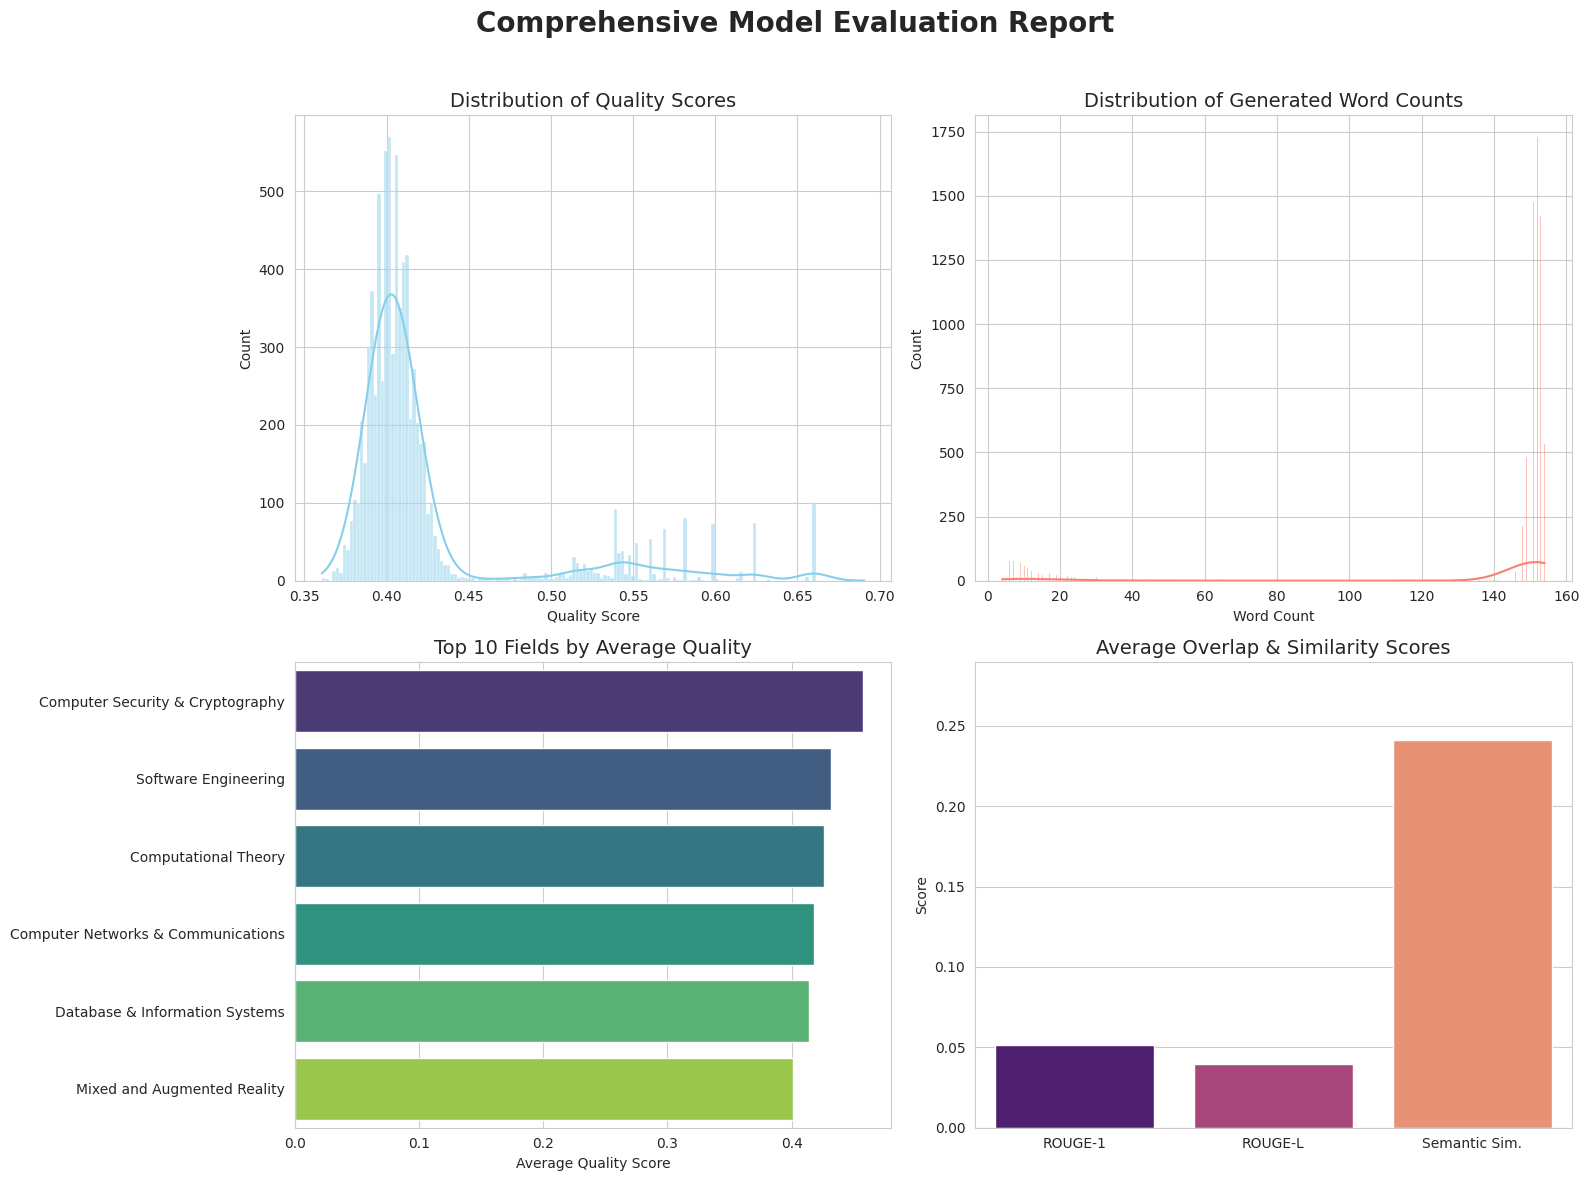


Evaluation complete and saved to google drive


In [23]:
# defining the final generation parameters
FINAL_GENERATION_PARAMS = {
    'top_p': 0.9,
    'temperature': 1.0,
    'max_length': 150,
    'min_length': 15,
    'repetition_penalty': 1.1
}

# defining the checkpoint path on Google Drive
DRIVE_CHECKPOINT_PATH = '/content/drive/MyDrive/evaluation_checkpoint.json'

# initializing the evaluation pipeline
pipeline = IntegratedEvaluationPipeline(model, vocabulary, device)

# running the complete evaluation with checkpointing
final_report = pipeline.run_complete_evaluation(
    test_df=test_df,
    generation_params=FINAL_GENERATION_PARAMS,
    checkpoint_path=DRIVE_CHECKPOINT_PATH
)

# saving the completed report to Google Drive
pipeline.save_results(final_report, filepath='/content/drive/MyDrive/final_evaluation_report.json')

# generating and saving the final plots to Google Drive
create_visual_report(final_report, save_dir='/content/drive/MyDrive/evaluation_plots')

print("\nEvaluation complete and saved to google drive")

In [33]:
class ResearchGapGenerator:
    def __init__(self, model, vocabulary, device):
        self.model = model
        self.vocabulary = vocabulary
        self.device = device
        self.generation_params = {
            'top_p': 0.9,
            'temperature': 1.2,
            'max_length': 150,
            'min_length': 15,
            'repetition_penalty': 1.3
        }

    def generate(self, paper_title, paper_abstract):
        input_text = f"Title: {paper_title}\nAbstract: {paper_abstract[:500]}"

        generated_gaps = generate_research_gaps(
            self.model, self.vocabulary, input_text, self.device,
            **self.generation_params
        )

        return generated_gaps

In [37]:
gap_generator = ResearchGapGenerator(model, vocabulary, device)

print("Please enter the details for the paper you want to analyze.")
paper_title = input("Enter the paper title:")
paper_abstract = input("Enter the paper abstract:")

result = gap_generator.generate(paper_title, paper_abstract)

print("\nGenerated Research Gap:")
print(result)

Please enter the details for the paper you want to analyze.
Enter the paper title:An Algorithm for Optimizing Query Performance in Relational Databases
Enter the paper abstract:We propose a new query optimization algorithm that dynamically rewrites SQL queries to minimize execution time. Our method analyzes the query plan and restructures joins and indexes to improve I/O efficiency, leading to a significant speedup on large-scale datasets.

Generated Research Gap:
Future research should explore 1 to participants investigate collective if mechanisms all instance tables agents observations under our of costs research dilemmas disaster while think scale face limited from scale however real collected is developing example am anti scale.


In [ ]:
gap_generator = ResearchGapGenerator(model, vocabulary, device)

print("Please enter the details for the paper you want to analyze.")
paper_title = input("Enter the paper title:")
paper_abstract = input("Enter the paper abstract:")

result = gap_generator.generate(paper_title, paper_abstract)

print("\nGenerated Research Gap:")
print(result)

In [ ]:
gap_generator = ResearchGapGenerator(model, vocabulary, device)

print("Please enter the details for the paper you want to analyze.")
paper_title = input("Enter the paper title:")
paper_abstract = input("Enter the paper abstract:")

result = gap_generator.generate(paper_title, paper_abstract)

print("\nGenerated Research Gap:")
print(result)